## Physio Itera Dataset Extraction - Face Detection

**subject**: Toby White Eyes Blue Dragon

Whut, 3 min operations, what a lucky day for me

**
Blue eyes Toby diff in 5 - 10 Beat compare to GT
**

v0.1

-- Status Logging

In [676]:
## Import Dependencies
import numpy as np
import mediapipe as mp
import pandas as pd
import cv2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt
import scipy
import os
import math
from typing import Tuple, Union

In [677]:
## Setup the Base Path
subject="tryx6"
base_path=f"../Physio-Itera/Dataset/{subject}/"
base_model="../Models/blaze_face_short_range.tflite"

## Load the video Folder 
video_folder=base_path+"rgb"

## Load the GT
gt_path=base_path+f"vernier/{subject}_vernier_ecg.csv"

## Define the POS method
Pos Method by Wenjin Wang

In [678]:
## Core method POS 
def POS(signal, **kargs):
    """
    POS method on CPU using Numpy.

    The dictionary parameters are: {'fps':float}.

    Wang, W., den Brinker, A. C., Stuijk, S., & de Haan, G. (2016). Algorithmic principles of remote PPG. IEEE Transactions on Biomedical Engineering, 64(7), 1479-1491. 
    """
    """
    eps: A small constant (10^-9) used to prevent division by zero in normalization steps.
    X: The input signal, which is a 3D array where:
    e: Number of estimators or regions in the frame (like different parts of the face).
    c: Color channels (3 for RGB).
    f: Number of frames.
    w: Window length, determined by the camera's frame rate (fps). For example, at 20 fps, w would be 32 (which corresponds to about 1.6 seconds of video).
    """
    eps = 10**-9
    X = signal
    e, c, f = X.shape # Number of estimators, color channels, and frames
    w = int(1.6 * kargs['fps']) # Window length in frames

    """
    P: A fixed 2x3 matrix used for the projection step. It defines how to transform the color channels (RGB) into a new space.
    Q: This is a stack of the matrix P repeated e times, where each P corresponds to an estimator (region of interest) in the video.
    """
    P = np.array([[0, 1, -1], [-2, 1, 1]])
    Q = np.stack([P for _ in range(e)], axis = 0)

    """
    H: A matrix to store the estimated heart rate signal over time for each estimator.
    n: The current frame in the sliding window.
    m: The start index of the sliding window (calculating which frames are part of the current window).
    """
    H = np.zeros((e, f))
    for n in np.arange(w, f):
        # Start index of sliding window 
        m = n - w + 1

        """
        Temporal Normalization (Equation 5 from the paper): This step ensures that the signal is invariant to global lighting changes and other noise factors.
        """
        Cn = X[:, :, m:(n+1)]
        M = 1.0 / (np.mean(Cn, axis = 2) + eps)
        M = np.expand_dims(M, axis=2) # shape [e, c, w]
        Cn = np.multiply(Cn, M)

        """
        Projection (Equation 6 from the paper): This step transforms the RGB values into a space where the signal from blood flow (heart rate) is more distinct.
        """
        S = np.dot(Q, Cn)
        S = S[0, :, :, :]
        S = np.swapaxes(S, 0, 1) 

        """
        Tuning (Equation 7 from the paper): This step adjusts the projected components to make the heart rate signal clearer.
        """
        S1 = S[:, 0, :]
        S2 = S[:, 1, :]
        alpha = np.std(S1, axis=1) / (eps + np.std(S2, axis=1))
        alpha - np.expand_dims(alpha, axis=1)
        Hn = np.add(S1, alpha * S2)
        Hnm = Hn - np.expand_dims(np.mean(Hn, axis=1), axis=1)

        """
        Overlap-Adding (Equation 8 from the paper): This step combines the processed signals from each frame to form the final output heart rate signal.
        """
        H[:, m:(n + 1)] = np.add(H[:, m:(n + 1)], Hnm)  # Add the tuned signal to the output matrix

    return H


### Setup Mediapipe Face Detection ROI.

Setup the functions and properties for doing the RPPGs

In [679]:
## Create Facelandmarker Object
base_options = python.BaseOptions(model_asset_path=base_model)
FaceDetector = mp.tasks.vision.FaceDetector
FaceDetectorOptions = mp.tasks.vision.FaceDetectorOptions
VisionRunningMode = mp.tasks.vision.RunningMode
options = FaceDetectorOptions(
    base_options=base_options,
    min_detection_confidence = 0.6,
    running_mode = VisionRunningMode.IMAGE,
)
detector = vision.FaceDetector.create_from_options(options)

## HRV - v0.1

Extraction the RGB Signal over the entire frame image

In [680]:
""" RGB Signal Variables

    Variables to store the RGB signals from the left and right cheeks,
    as well as the combined signal from both cheeks.

"""
# Lists to store combined RGB values
combined_r_signal, combined_g_signal, combined_b_signal = [], [], []

## Utils
fs = 30 # Sampling rate in Hz for RPPG signal

In [681]:
video_files = sorted(os.listdir(video_folder))

## print the len of folder
print(len(video_files))

## Get the first image
image_path = os.path.join(video_folder, video_files[0])
image = cv2.imread(image_path)

## Get the height and width
h, w, _ = image.shape

print(h, w)

1800
1080 1920


Face Detected


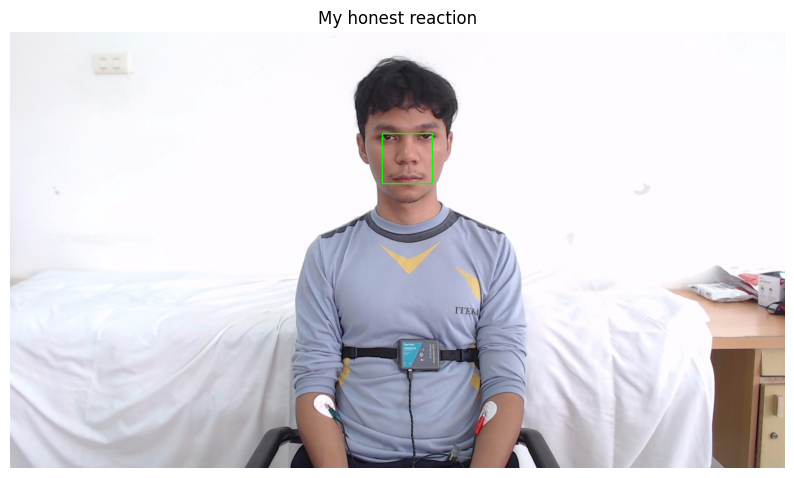

In [682]:
scaling_factor = 0.5

# X should be increasing, y should be decreasing
# w should be decreasing, h should be decreasing to fit the box into the face

# Fixed adjustment values (in pixels)
margin_x = 50  # Adjust horizontally
margin_y = 50  # Adjust vertically

# Get the first image
image_path = os.path.join(video_folder, video_files[0])
image = cv2.imread(image_path)

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mp_image = mp.Image(
    image_format=mp.ImageFormat.SRGB,
    data=image_rgb
)

## Get the landkmarks
result = detector.detect(mp_image)

if result.detections:
    ## Check if face detected
    print("Face Detected")
    for detection in result.detections:

        # # # Get the bounding box coordinates
        # bboxC = detection.bounding_box
        # x, y, w, h = bboxC.origin_x, bboxC.origin_y, bboxC.width, bboxC.height

        # # Extract the ROI
        # face_roi = image_rgb[y:y+h, x:x+w]

        # # Calculate mean RGB values
        # mean_rgb = cv2.mean(face_roi)[:3]

        # # Print the mean RGB values
        # print("Mean RGB values of the face ROI:", mean_rgb)

        # # Draw the bounding box on the image
        # cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # ========================

        ## Get the Bounding box
        bboxC = detection.bounding_box
        x, y, w, h = bboxC.origin_x, bboxC.origin_y, bboxC.width, bboxC.height

        new_x = int(x + margin_x)
        new_y = int(y + margin_y)

        new_w = int(w * scaling_factor)
        new_h = int(h * scaling_factor)

        ## Draw the rectangle
        cv2.rectangle(image_rgb, (new_x, new_y), (new_x + new_w, new_y + new_h), (0, 255, 0), 2)

        # ========================

        ## Get the bounding box coordinate
        # bboxC = detection.bounding_box
        # x, y, w, h = bboxC.origin_x, bboxC.origin_y, bboxC.width, bboxC.height

        # ## Calculate the center of the bounding box
        # center_x = x + w // 2 # True division on the center
        # center_y = y + h // 2

        # ## Apply new scaling factor
        # new_w = int(w * scaling_factor)
        # new_h = int(h * scaling_factor)

        # ## Recalculate the top-left edge
        # new_x = max(0, center_x - new_w // 2)
        # new_y = max(0, center_y - new_h // 2)

        # ## Ensure  the new ROI is within the image boundaries
        # new_x = min(new_x, image_rgb.shape[1] - new_w)
        # new_y = min(new_y, image_rgb.shape[0] - new_h)

        # ## Extract the ROI
        # mean_rgb = cv2.mean(image_rgb[new_y: new_y + new_h, new_x:new_x+new_w])[:3] # Colors space of RGB

        # # # Print the mean RGB values
        # print("Mean RGB values of the face ROI:", mean_rgb)

        # ## Print the mean RGB values
        # cv2.rectangle(image_rgb, (new_x, new_y), (new_x + new_w, new_y + new_h), (0, 255, 0), 2)

# Display the image
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.title('My honest reaction')
plt.axis('off')
plt.show()

In [683]:
"""
Main Loop: Stuff
"""
# Load the video frames
video_files = sorted(os.listdir(video_folder))

# Load the face landmarks
for i in range(len(video_files) - 1): ## The last one is
    # Load the image
    image_path = os.path.join(video_folder, video_files[i])
    image = cv2.imread(image_path)

    ## Detect the face area using shape
    h, w, _ = image.shape

    ## Converting into RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## Seting up the Mediapipe Image
    mp_image = mp.Image(
        image_format=mp.ImageFormat.SRGB,
        data=image_rgb
    )

    if result.detections:
        ## Check if face detected
        print("Face Detected")
        for detection in result.detections:

            ## Get the Bounding box
            bboxC = detection.bounding_box
            x, y, w, h = bboxC.origin_x, bboxC.origin_y, bboxC.width, bboxC.height

            new_x = int(x + margin_x)

            new_w = int(w * scaling_factor)
            new_h = int(h * scaling_factor + margin_y)

            ## Get the ROI
            face_roi = image_rgb[y:y+new_h, new_x:new_x+new_w]

            ## Calculate the Mean
            mean_rgb = cv2.mean(face_roi)[:3]
            
            # Append the combined RGB values to the respective lists
            combined_r_signal.append(mean_rgb[0])
            combined_g_signal.append(mean_rgb[1])
            combined_b_signal.append(mean_rgb[2])



Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face Detected
Face D

In [684]:
## Print sample of the combined RGB signals
print("Sample of the Combined RGB Signals:")
print(len(combined_r_signal))

Sample of the Combined RGB Signals:
1799


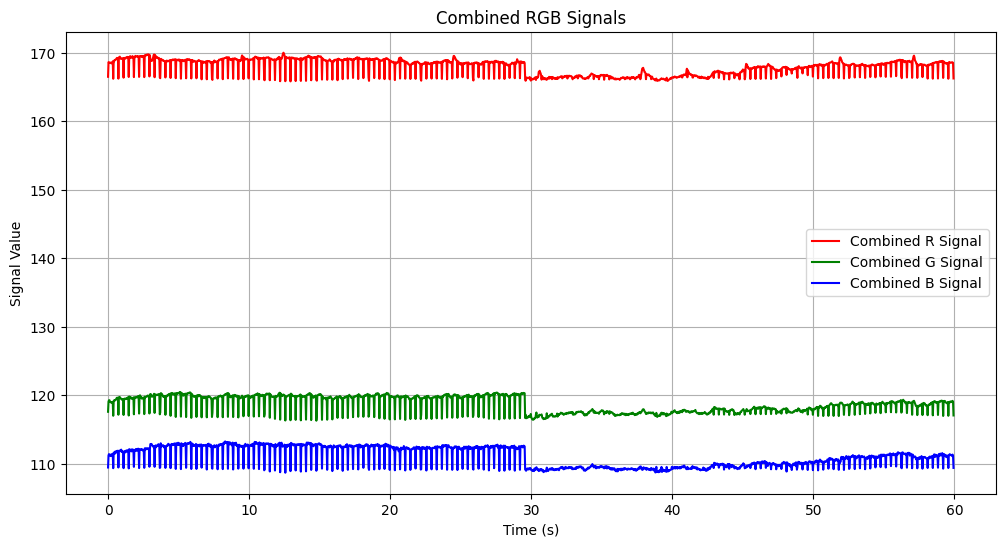

In [685]:
# Create a time array based on the sampling rate and the number of samples
time_rgb = np.arange(len(combined_r_signal)) / fs

# Plot the combined RGB signals
plt.figure(figsize=(12, 6))
plt.plot(time_rgb, combined_r_signal, label='Combined R Signal', color='red')
plt.plot(time_rgb, combined_g_signal, label='Combined G Signal', color='green')
plt.plot(time_rgb, combined_b_signal, label='Combined B Signal', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Signal Value')
plt.title('Combined RGB Signals')
plt.legend()
plt.grid(True)
plt.show()

## Process the RPPG signal
Doing the RPPG process stuff ayaya

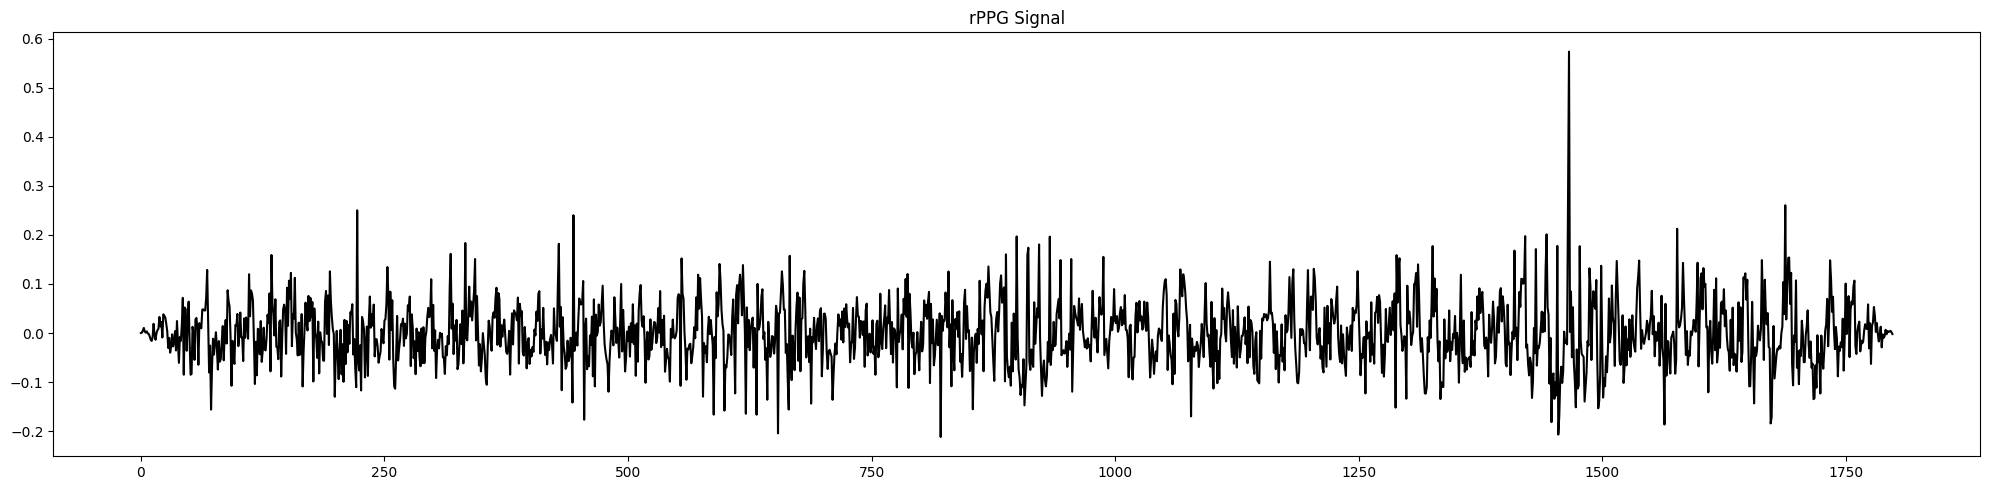

In [686]:
## Calculating the RPPG Signal
rgb_signals = np.array([combined_r_signal, combined_g_signal, combined_b_signal])
rgb_signals = rgb_signals.reshape(1, 3, -1)
rppg_signal = POS(rgb_signals, fps=30)
rppg_signal = rppg_signal.reshape(-1)

# Show the RPPG Signal
plt.figure(figsize=(20, 5))
plt.plot(rppg_signal, color='black')
plt.title('rPPG Signal')
plt.tight_layout()
plt.show()

In [687]:
## Print the len of RPPG signal
print(len(rppg_signal))

1799


## Post Pre-processing Signal RPPG
Post processing stuff

In [688]:
def preprocess_ppg(signal, fs = 30):
    """ Computes the Preprocessed PPG Signal, this steps include the following:
        1. Moving Average Smoothing
        2. Bandpass Filtering
        
        Parameters:
        ----------
        signal (numpy array): 
            The PPG Signal to be preprocessed
        fs (float): 
            The Sampling Frequency of the Signal
            
        Returns:
        --------
        numpy array: 
            The Preprocessed PPG Signal
    
    """ 

    # Moving Average Smoothing
    window = int(fs * 0.15)  # 150ms window
    smoothed_signal = np.convolve(signal, np.ones(window)/window, mode='same')

    b, a = scipy.signal.butter(2, [0.5, 2.5], btype='band', fs=fs)
    filtered = scipy.signal.filtfilt(b, a, smoothed_signal)
    
    # Additional lowpass to remove high-frequency noise
    b2, a2 = scipy.signal.butter(3, 2.5, btype='low', fs=fs)
    filtered = scipy.signal.filtfilt(b2, a2, filtered)
    
    # Moving average smoothing
    window = int(fs * 0.15)  # 150ms window
    filtered_signal = np.convolve(filtered, np.ones(window)/window, mode='same')

    # Normalize the signal
    normalized_signal = (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal))


    return normalized_signal


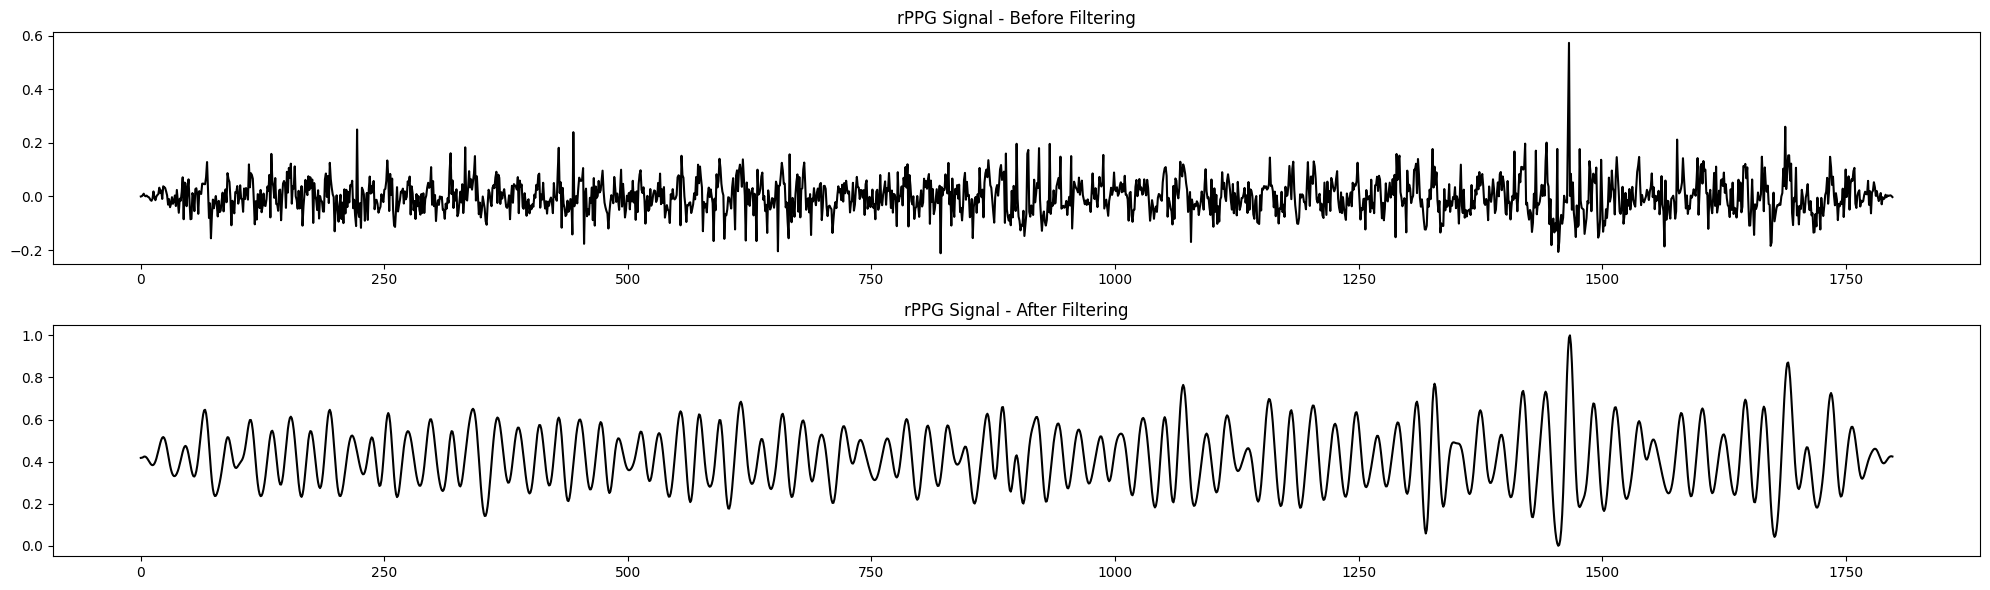

In [689]:
## Filter RPPG Signal
preprocessed_signal = preprocess_ppg(rppg_signal, fs=30)

## Show the Filtered RPPG Signal
fig, ax = plt.subplots(2, 1, figsize=(20, 6))
ax[0].plot(rppg_signal, color='black')
ax[0].set_title('rPPG Signal - Before Filtering')
ax[1].plot(preprocessed_signal, color='black')
ax[1].set_title('rPPG Signal - After Filtering')
plt.tight_layout()
plt.show()

## Let's obtain the PPG

In [690]:
## Since it have two columns, date and value, we will use the value column
gt_ppg = pd.read_csv(gt_path, usecols=[1], header=None).values

## Flatten the GT PPG
gt_ppg = gt_ppg.flatten()

## Print the first 5 rows of the second columns
print(len(gt_ppg)) 

12000


## Downlsampling the GT to match with 30 Hz
Since the original sampling rate is 200Hz, downsample this to 30Hz to match with the Video

1800


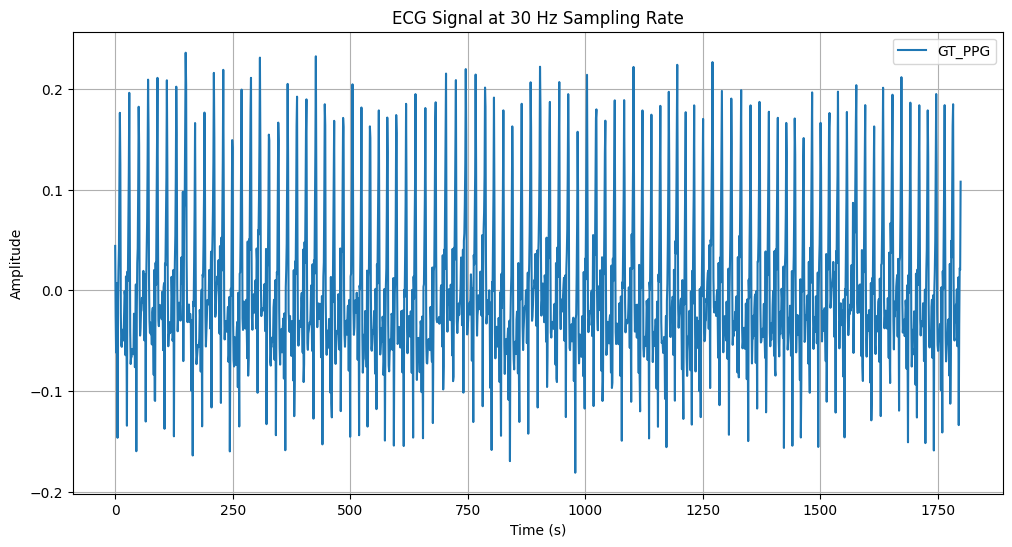

In [691]:
## Downsampling the GT from 200 Hz to 30 Hz
original_fs = 200
new_fs = 30

## Downsampling the GT PPG Signal
gt_ppg = scipy.signal.resample(gt_ppg, int(len(gt_ppg) * new_fs / original_fs))

## Print the len of GT PPG
print(len(gt_ppg))

plt.figure(figsize=(12, 6))
plt.plot(gt_ppg, label='GT_PPG')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('ECG Signal at 30 Hz Sampling Rate')
plt.legend()
plt.grid(True)
plt.show()

In [692]:
## print shape of gt signal
print(gt_ppg.shape)

(1800,)


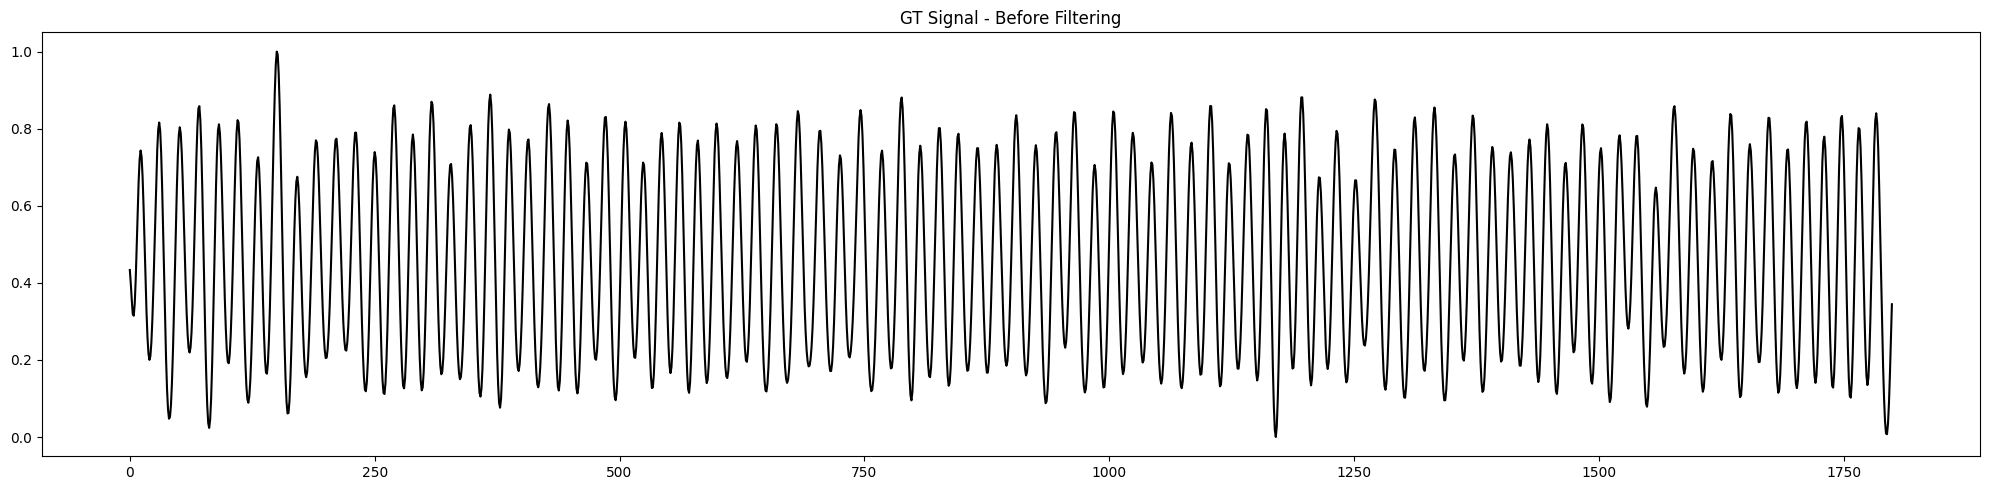

In [693]:
## Post-Processing GT Signal
gt_ppg = preprocess_ppg(gt_ppg, fs=30)

## Show the Filtered GT Signal
plt.figure(figsize=(20, 5))
plt.plot(gt_ppg, color='black')
plt.title('GT Signal - Before Filtering')
plt.tight_layout()
plt.show()

Number of Peaks in rPPG Signal: 85
Number of Peaks in Ground Truth: 92


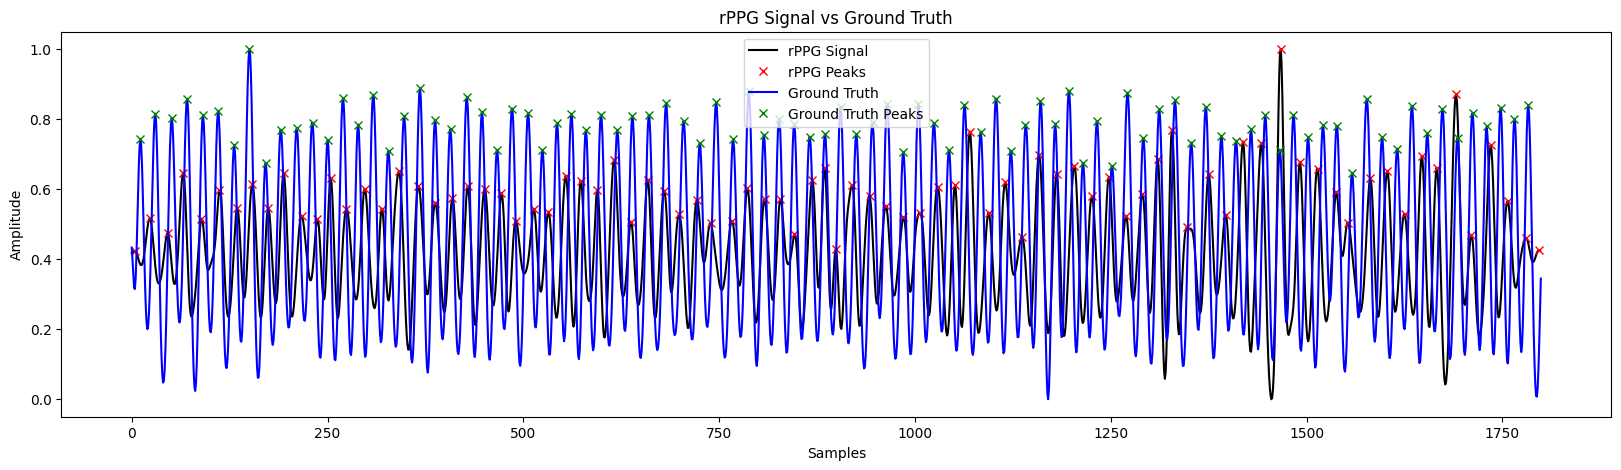

In [694]:
## Finds the Peaks from the Preprocessed Signal and Ground Truth
rppg_peaks, _  = scipy.signal.find_peaks(preprocessed_signal)
gt_peaks, _ = scipy.signal.find_peaks(gt_ppg)

## Print the Peaks
print(f"Number of Peaks in rPPG Signal: {len(rppg_peaks)}")
print(f"Number of Peaks in Ground Truth: {len(gt_peaks)}")   

## Create the linspace for duration
duration = 120 # 120 seconds
time = np.linspace(0, duration, len(preprocessed_signal))

## Plot the Signal
plt.figure(figsize=(20, 5)) 
plt.plot(preprocessed_signal, color='black', label='rPPG Signal')
plt.plot(rppg_peaks, preprocessed_signal[rppg_peaks], "x", color='red', label='rPPG Peaks')
plt.plot(gt_ppg, color='blue', label='Ground Truth')
plt.plot(gt_peaks, gt_ppg[gt_peaks], "x", color='green', label='Ground Truth Peaks')
plt.title('rPPG Signal vs Ground Truth')
plt.legend(['rPPG Signal', 'rPPG Peaks', 'Ground Truth', 'Ground Truth Peaks'])
# plt.xlabel('Time (s)')
plt.xlabel("Samples")
plt.ylabel('Amplitude')
plt.legend()
plt.show()